In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import scipy.stats as stats
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "Phi_inverse_transform_sampling.h5py"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi','j7_phi','j7_phi', 'j8_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi']
# output_keys = ['th_eta','th_phi', 'tl_eta', 'tl_phi']

output_length = len(output_keys)
input_length = len(input_keys)

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
def phi_transform(arr):
    mean = np.mean(arr)
    arr = (arr-mean)
    max0 = np.max(np.abs(arr))
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return (z, max0, mean)

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def meanmax_transform(arr):
    mean = np.mean(arr)
    arr = arr-mean
    max0 = np.max(np.abs(arr))
    z = arr/max0
    return (z, max0, mean)

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean
    
def scale_arrays(keys):
    arrays = []
    maxi0 = []
    mean = []
    for x in keys:
        var = np.array(dataset.get(x))[0:crop0]
        if x in phi_keys:
            arr, max0, mu = phi_transform(var)
        else:
            arr, max0, mu = meanmax_transform(var)
        arrays.append(arr)
        maxi0.append(max0)
        mean.append(mu)
    arrays = np.stack(arrays, axis=1)
    return (arrays, maxi0, mean)

def invscale_arrays(keys, maxi0, mean, arrays):
    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        max0 = maxi0[i]
        mu = mean[i]
        if keys[i] in phi_keys:
            total.append(invphi_transform(z, max0, mu))
        else:
            total.append(invmeanmax_transform(z, max0, mu))
    return np.stack(total,1) 

In [7]:
# Convert into numpy arrays and mean normalize
crop0 =  1000000 # Must be even

total_input, in_max0, in_mean = scale_arrays(input_keys)

total_output, out_max0, out_mean = scale_arrays(output_keys)

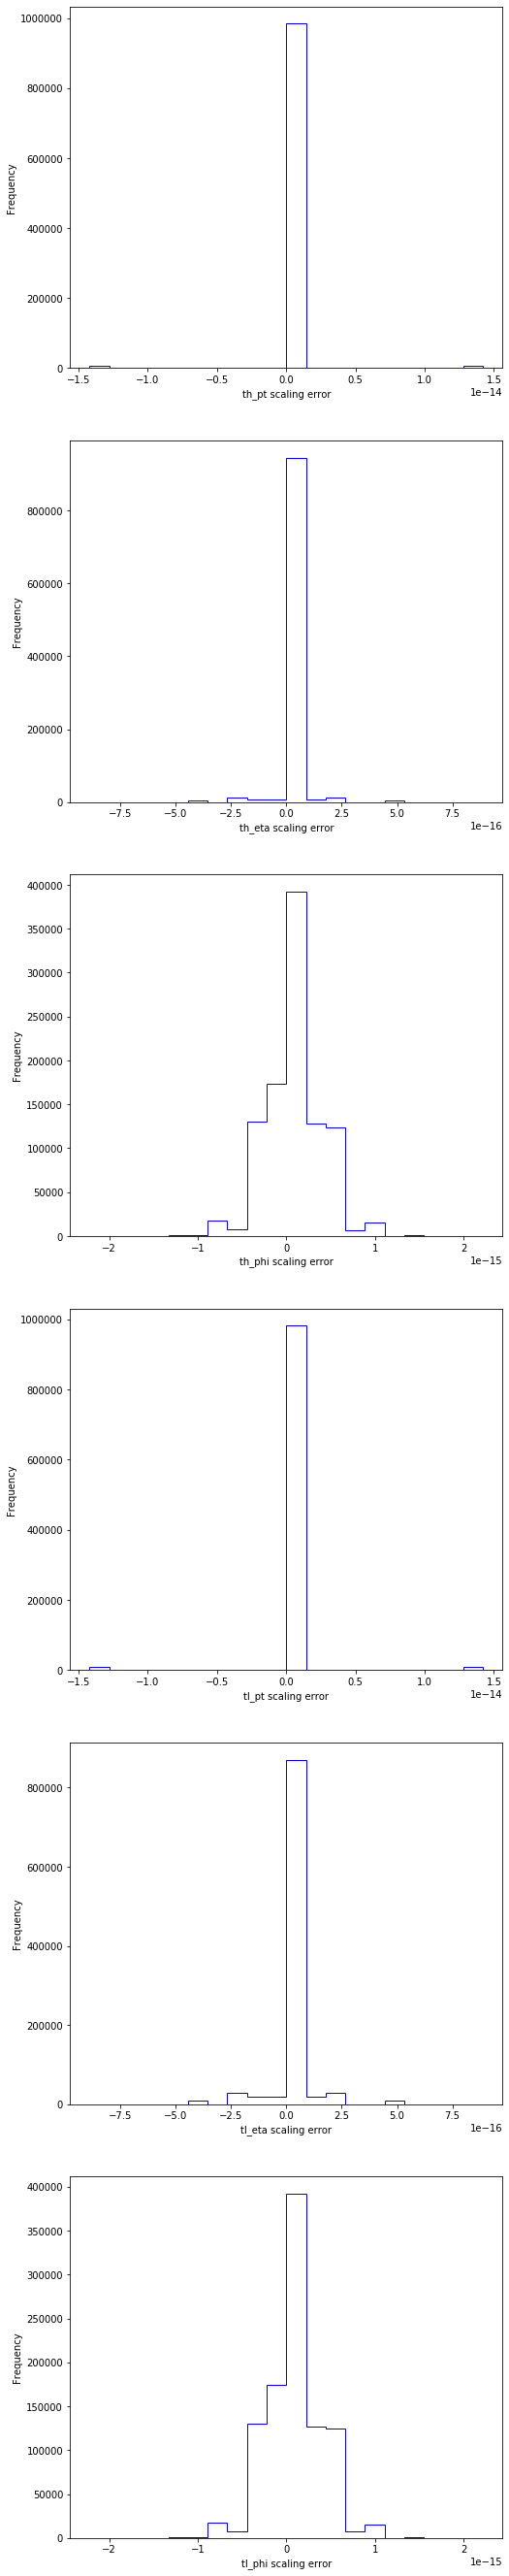

In [8]:
# Test inverse scaling

out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(800000, 45) (800000, 6)
(200000, 45) (200000, 6)


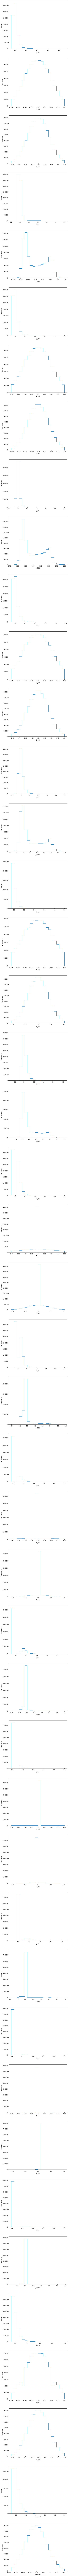

In [11]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [12]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23552     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 270,854
Trainable params: 270,854
Non-trainable params: 0
__________________________________________________

In [14]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1397 - mse: 0.0499 - val_loss: 0.1281 - val_mse: 0.0461
Epoch 2/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1203 - mse: 0.0450 - val_loss: 0.1132 - val_mse: 0.0441
Epoch 3/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1072 - mse: 0.0434 - val_loss: 0.1018 - val_mse: 0.0428
Epoch 4/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0970 - mse: 0.0422 - val_loss: 0.0926 - val_mse: 0.0418
Epoch 5/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0889 - mse: 0.0413 - val_loss: 0.0856 - val_mse: 0.0410
Epoch 6/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0828 - mse: 0.0407 - val_loss: 0.0802 - val_mse: 0.0405
Epoch 7/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0779 - mse: 0.0402 - val_loss: 0.0759 - val_mse: 0.0401
Epoch 8/2048
1250/1250 [========================

Epoch 61/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0423 - mse: 0.0346 - val_loss: 0.0427 - val_mse: 0.0350
Epoch 62/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0422 - mse: 0.0345 - val_loss: 0.0426 - val_mse: 0.0350
Epoch 63/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0421 - mse: 0.0345 - val_loss: 0.0425 - val_mse: 0.0350
Epoch 64/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0420 - mse: 0.0345 - val_loss: 0.0424 - val_mse: 0.0349
Epoch 65/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0419 - mse: 0.0345 - val_loss: 0.0423 - val_mse: 0.0349
Epoch 66/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0418 - mse: 0.0344 - val_loss: 0.0422 - val_mse: 0.0349
Epoch 67/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0417 - mse: 0.0344 - val_loss: 0.0421 - val_mse: 0.0349
Epoch 68/2048
1250/1250 [================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0387 - mse: 0.0334 - val_loss: 0.0394 - val_mse: 0.0341
Epoch 121/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0387 - mse: 0.0333 - val_loss: 0.0394 - val_mse: 0.0341
Epoch 122/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0386 - mse: 0.0333 - val_loss: 0.0393 - val_mse: 0.0340
Epoch 123/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0386 - mse: 0.0333 - val_loss: 0.0393 - val_mse: 0.0340
Epoch 124/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0386 - mse: 0.0333 - val_loss: 0.0393 - val_mse: 0.0340
Epoch 125/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0385 - mse: 0.0333 - val_loss: 0.0393 - val_mse: 0.0340
Epoch 126/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0385 - mse: 0.0333 - val_loss: 0.0392 - val_mse: 0.0340
Epoch 127/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0373 - mse: 0.0326 - val_loss: 0.0383 - val_mse: 0.0336
Epoch 180/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0373 - mse: 0.0326 - val_loss: 0.0383 - val_mse: 0.0336
Epoch 181/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0373 - mse: 0.0326 - val_loss: 0.0383 - val_mse: 0.0336
Epoch 182/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0373 - mse: 0.0326 - val_loss: 0.0383 - val_mse: 0.0336
Epoch 183/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0372 - mse: 0.0326 - val_loss: 0.0382 - val_mse: 0.0336
Epoch 184/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0372 - mse: 0.0326 - val_loss: 0.0382 - val_mse: 0.0336
Epoch 185/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0372 - mse: 0.0326 - val_loss: 0.0382 - val_mse: 0.0336
Epoch 186/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0365 - mse: 0.0321 - val_loss: 0.0378 - val_mse: 0.0334
Epoch 239/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0365 - mse: 0.0321 - val_loss: 0.0378 - val_mse: 0.0333
Epoch 240/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0365 - mse: 0.0321 - val_loss: 0.0378 - val_mse: 0.0333
Epoch 241/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0365 - mse: 0.0321 - val_loss: 0.0378 - val_mse: 0.0333
Epoch 242/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0365 - mse: 0.0320 - val_loss: 0.0377 - val_mse: 0.0333
Epoch 243/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0364 - mse: 0.0320 - val_loss: 0.0377 - val_mse: 0.0333
Epoch 244/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0364 - mse: 0.0320 - val_loss: 0.0377 - val_mse: 0.0333
Epoch 245/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0375 - val_mse: 0.0331
Epoch 298/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0375 - val_mse: 0.0331
Epoch 299/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0375 - val_mse: 0.0331
Epoch 300/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0374 - val_mse: 0.0331
Epoch 301/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0374 - val_mse: 0.0331
Epoch 302/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0374 - val_mse: 0.0331
Epoch 303/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0359 - mse: 0.0316 - val_loss: 0.0374 - val_mse: 0.0331
Epoch 304/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 357/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 358/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 359/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 360/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 361/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0354 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 362/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0354 - mse: 0.0312 - val_loss: 0.0373 - val_mse: 0.0330
Epoch 363/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0372 - val_mse: 0.0329
Epoch 416/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0372 - val_mse: 0.0329
Epoch 417/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0372 - val_mse: 0.0329
Epoch 418/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0372 - val_mse: 0.0329
Epoch 419/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0372 - val_mse: 0.0329
Epoch 420/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0372 - val_mse: 0.0329
Epoch 421/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0309 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 422/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 475/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 476/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 477/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 478/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 479/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 480/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0348 - mse: 0.0306 - val_loss: 0.0371 - val_mse: 0.0329
Epoch 481/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 534/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 535/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 536/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 537/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 538/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 539/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0303 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 540/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0301 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 593/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0300 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 594/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0300 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 595/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0300 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 596/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0300 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 597/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0300 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 598/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0300 - val_loss: 0.0370 - val_mse: 0.0328
Epoch 599/2048
1250/1250 [=======================

In [15]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Phi_inverse_transform_sampling.h5py/assets


Text(0.5, 1.0, 'MSE loss')

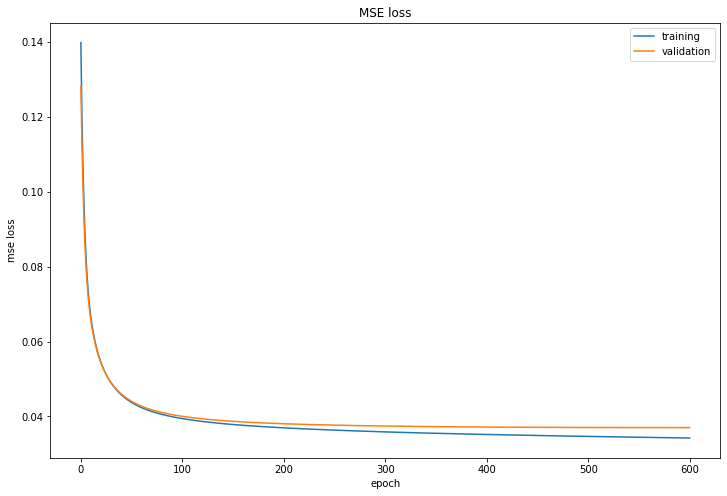

In [16]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [17]:
predictions = model.predict(test_input)

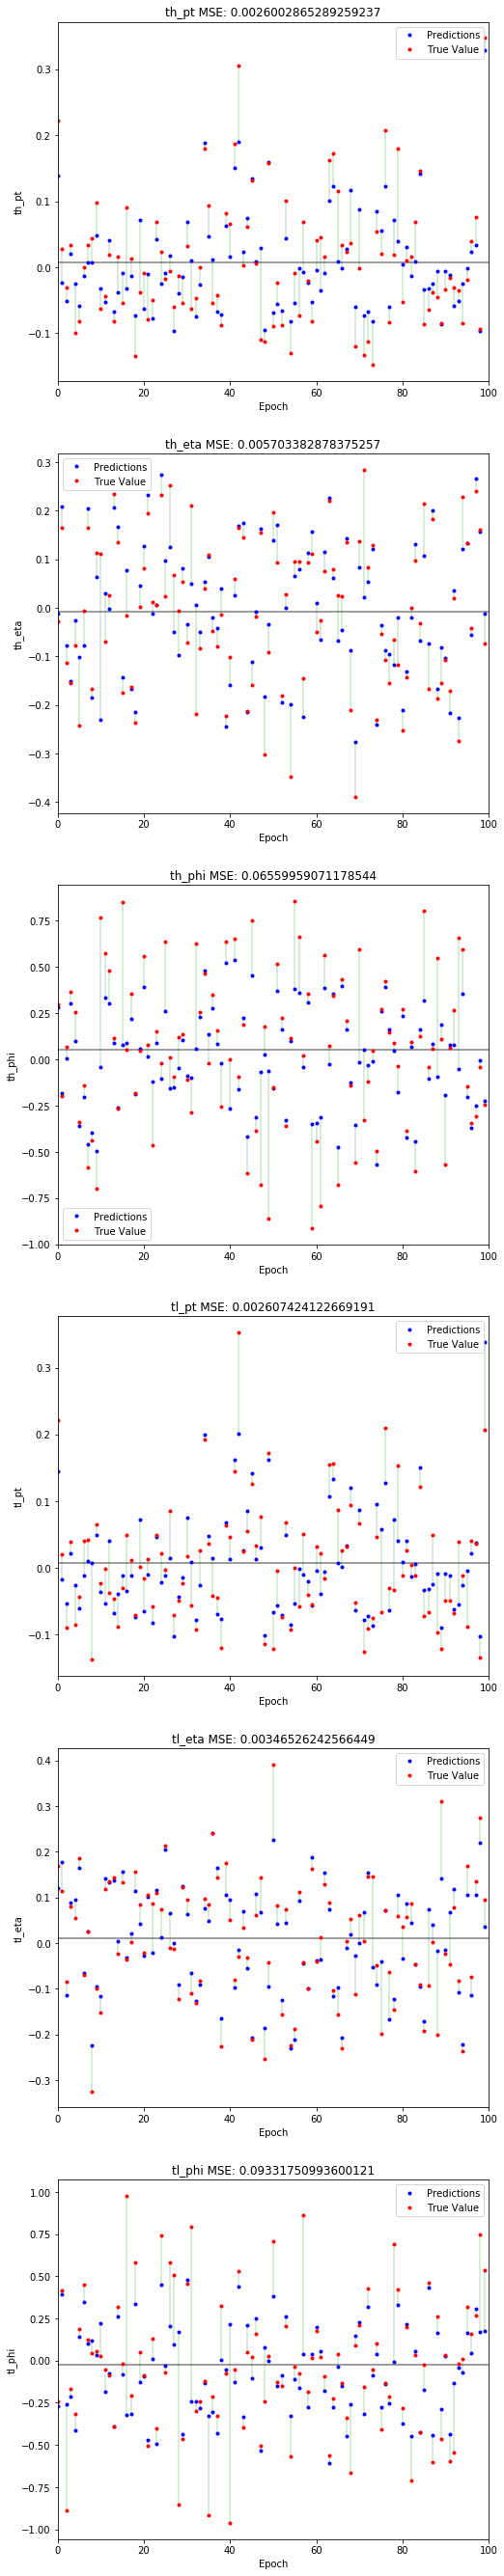

In [18]:
# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [19]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.03266265573673336
th_pt MSE :  0.0029163317
th_eta MSE :  0.0082131413
th_phi MSE :  0.0950860900
tl_pt MSE :  0.0026529167
tl_eta MSE :  0.0041945080
tl_phi MSE :  0.0829129466


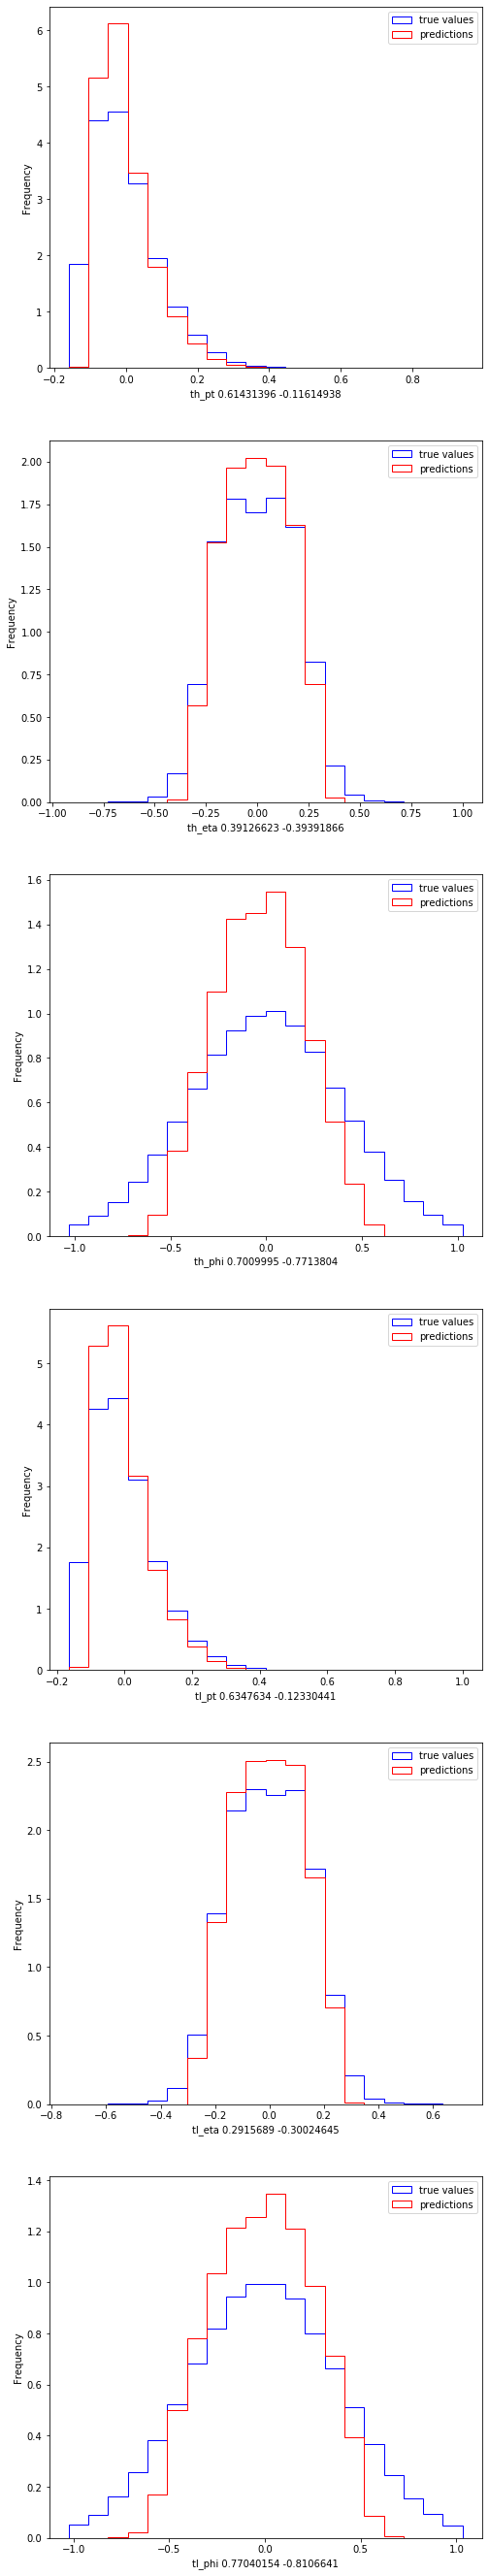

In [20]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [21]:
print(output_keys, out_max0)

['th_pt', 'th_eta', 'th_phi', 'tl_pt', 'tl_eta', 'tl_phi'] [820.5357456398024, 8.582150461262373, 3.142285751589274, 798.3900403535235, 10.716707039952096, 3.142329726722945]


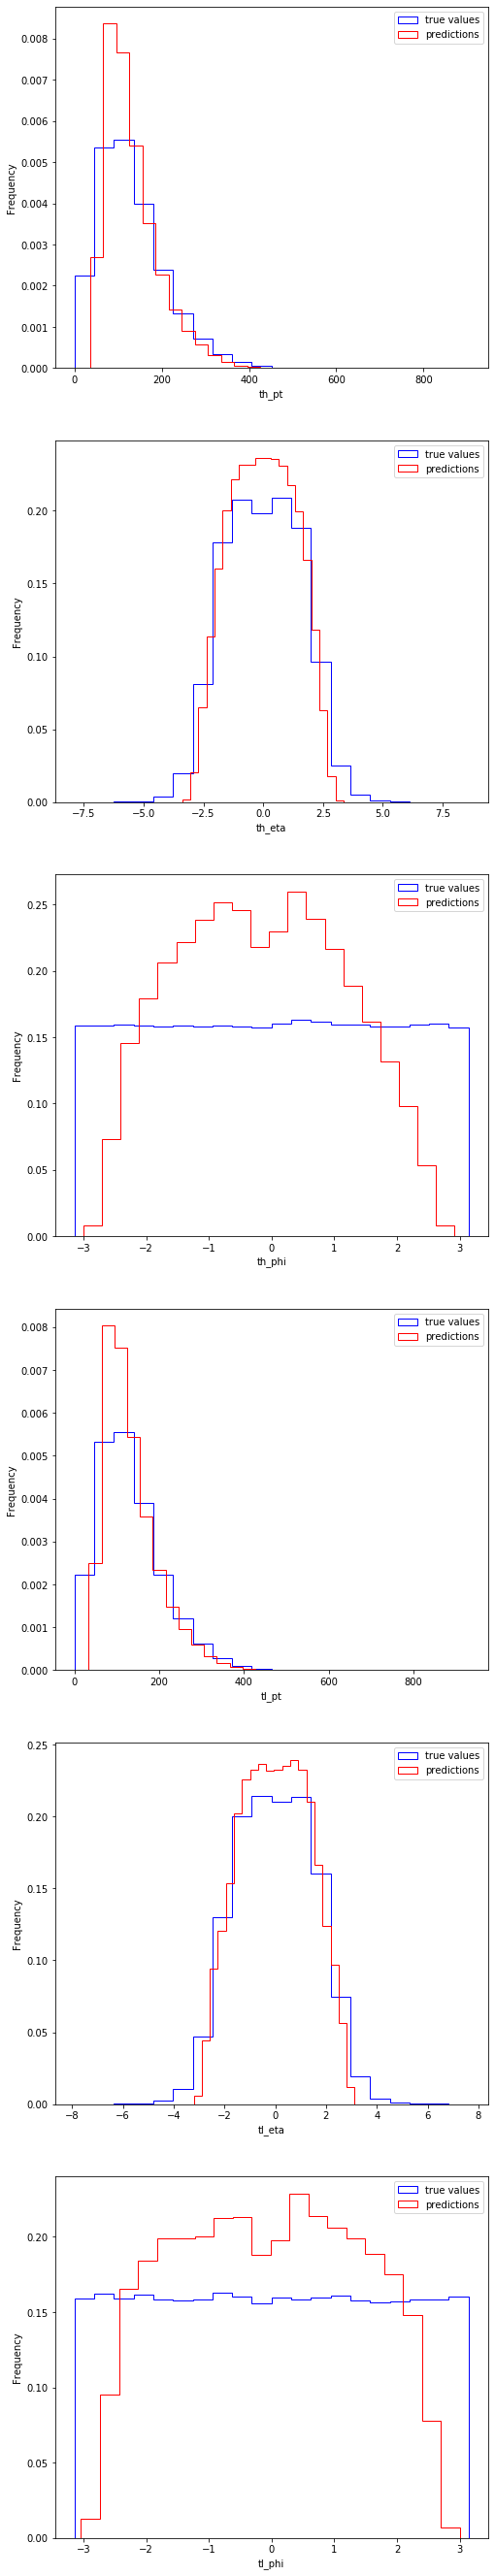

In [22]:
# Histograms to the original scale 

total_predictions = model.predict(total_input) 
out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)[split:,:]

predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [23]:
for i in range(output_length):
    MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] -out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1963.5046388173
Original Scale th_eta MSE :  0.6049250118
Original Scale th_phi MSE :  1.9107220251
Original Scale tl_pt MSE :  1691.0398377102
Original Scale tl_eta MSE :  0.4817300578
Original Scale tl_phi MSE :  1.5767196223


In [24]:
def invphi_transform(z, max0, mean):
    z1, z2 = z0[0:len(z)//2], z0[len(z)//2:]
    s1 = np.exp(-1*(z1**2+z2**2)/2)
    x1 = z1*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    y1 = z2*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    arr = np.append(x1, y1)
    arr = arr*max0*2.2+mean
    
    return arr 